# Data modeling #

In [10]:
#Libraries
import numpy as np 
import pandas as pd 
import tensorflow
import time

#Models  
from sklearn.svm import SVR
import xgboost as xgb
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout


#Performance metrics
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score,accuracy_score

#Cross validation, train-test split and kfold
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict, KFold

#Grid Search
from sklearn.model_selection import GridSearchCV

In [11]:
pd.set_option('display.max_colwidth', None)  # For Pandas version < 1.0.0, use -1 instead of None


In [12]:
df = pd.read_csv('cleanedData.csv')
df = df[df.columns[1:]]


In [13]:
seed = 1

In [14]:
def create_model():
    
    # create model
    model = Sequential()
    model.add(Dense(5, input_shape=(28,), activation='tanh'))
    model.add(Dense(1, activation='linear'))
    return model

tensorflow.random.set_seed(seed)


In [15]:
#Models

lr = {"name":"Linear Regression",
      "object": LinearRegression(),
      "paramsGrid": {},
      "requires_feature_selection": True,
      "requires_scalling":True,
      "needs_outliers_handling":True
}

rf = {"name":"Random Forest",
      "object": RandomForestRegressor(criterion='squared_error',
                               min_samples_leaf=3,
                               bootstrap=True,
                               oob_score=False,
                               random_state=seed,
                               verbose=0),
      "paramsGrid": {'max_depth': [3,4,5], 'min_samples_split': [3,4,5],'n_estimators': [300,500,800]},
      "requires_feature_selection": True,
      "requires_scalling":True,
      "needs_outliers_handling":True
}

ridge = {"name":"Ridge",
      "object": Ridge(),
      "paramsGrid": {'alpha':[10,20,29,29,30,31,32,33,35,40,45,50]},
      "requires_feature_selection": True,
      "requires_scalling":True,
      "needs_outliers_handling":True
}

lasso = {"name":"Lasso",
      "object": Lasso(max_iter=10000),
      "paramsGrid": {'alpha':[1e-4,1e-3,1e-2,1,5,10,20,30,35]},
      "requires_feature_selection": False,
      "requires_scalling":True,
      "needs_outliers_handling":True
}

svr = {
    "name": "Support Vector Regressor",
    "object": SVR(),
    "paramsGrid": [{'kernel': ['rbf'], 'gamma': [.0009,.001,.005],'C': [1500,2900,4000]},{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
    "requires_feature_selection": True,
    "requires_scalling": True,
    "needs_outliers_handling": True
}


boost = {"name":"XGBoost",
      "object": xgb.XGBRegressor(objective='reg:squarederror', seed=seed),
      "paramsGrid": {'colsample_bytree': [0.1,0.3,0.5], 'n_estimators':[10,15,17,20], 'max_depth': [2,3,4,5]}, 
      "requires_feature_selection": True,
      "requires_scalling":True,
      "needs_outliers_handling":True
}

nngrid = dict(optimizer__learning_rate=[0.1, 0.05, 0.01], optimizer__momentum=[0.8, 0.6, 0.4])
nn = { "name": "Neural Net",
    "object": KerasRegressor(model=create_model, loss='mean_squared_error',
                        optimizer=tensorflow.keras.optimizers.legacy.SGD,
                          epochs=100, batch_size=10, verbose=0),
    "paramsGrid": nngrid,
    "requires_feature_selection": True,
    "requires_scalling": True,
    "needs_outliers_handling": True
}

models = [nn,rf,lr,ridge,lasso,svr,boost]



In [16]:
def modeling(df,modelDict,seed=1,threshold_for_selection=.3,test_size=.3,cv_splits=5):
    
    #Feature selection
    if modelDict["requires_feature_selection"] == True:
        corr = df.corr()["ViolentCrimesPerPop"].sort_values(ascending=False)
        #Creates a new dataframe with the selected columns
        df = df[corr[corr > threshold_for_selection].index]

    

    X = df.drop('ViolentCrimesPerPop', axis=1)
    Y = df['ViolentCrimesPerPop']

   

    #Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=test_size,random_state=seed)

    #Kfold object
    kfold = KFold(n_splits=cv_splits, random_state=seed, shuffle=True)

    #Grid Search
    gridSearch = GridSearchCV(estimator=modelDict["object"],param_grid=modelDict["paramsGrid"],cv=kfold,scoring="r2") #If grid search is empty it doesn't do CV, just kfolds
    gridSearch.fit(X_train, y_train)

    #Getting best model
    bestModel = gridSearch.best_estimator_

    #Predictions 
    y_pred = bestModel.predict(X_test)
    

    return [modelDict['name'],mean_squared_error(y_test, y_pred),mean_absolute_error(y_test, y_pred),r2_score(y_test, y_pred),gridSearch.best_params_,bestModel]

In [17]:
#Main

results = pd.DataFrame(columns=['model','mse', 'mae', 'r2','hiperparameters','modelObject'])
times = []
for model in models:
    print(f'Making {model["name"]} model...')
    start = time.time()
    row = modeling(df,modelDict=model)

    end = time.time()
    delta = round(end-start,3)
    times.append(delta)

    results.loc[len(results)] = row

results["duration"] = times

results[[col for col in results.columns if col != "modelObject"]].sort_values(by='r2')

Making Neural Net model...
Making Random Forest model...
Making Linear Regression model...
Making Ridge model...
Making Lasso model...
Making Support Vector Regressor model...
Making XGBoost model...


,model,mse,mae,r2,hiperparameters,duration
3,Ridge,0.019681,0.094854,0.621684,{'alpha': 10},0.119
0,Neural Net,0.019652,0.097567,0.622228,"{'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.8}",132.902
1,Random Forest,0.019552,0.094677,0.624164,"{'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 500}",183.776
2,Linear Regression,0.019465,0.093890,0.625821,{},0.034
5,Support Vector Regressor,0.019460,0.092810,0.625919,"{'C': 2900, 'gamma': 0.001, 'kernel': 'rbf'}",23.920
6,XGBoost,0.019073,0.091634,0.633357,"{'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 20}",2.057
4,Lasso,0.018800,0.093173,0.638601,{'alpha': 0.0001},0.412


### Lasso is the best model, so we'll predict with completely new random data ###

In [18]:
X = df.drop('ViolentCrimesPerPop', axis=1)

In [19]:
np.random.seed(seed)
newX = pd.DataFrame(np.random.rand(X.shape[0]//100, X.shape[1]),columns=X.columns)
newX.head(4)



,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,RacialMatchCommPol,LandArea,PopDens,PctUsePubTrans,LemasGangUnitDeploy,LemasPctOfficDrugUn
0,0.417022,0.720324,0.000114,0.302333,0.146756,0.092339,0.186260,0.345561,0.396767,0.538817,...,0.449912,0.578390,0.408137,0.237027,0.903380,0.573679,0.002870,0.617145,0.326645,0.527058
1,0.885942,0.357270,0.908535,0.623360,0.015821,0.929437,0.690897,0.997323,0.172341,0.137136,...,0.907816,0.931972,0.013952,0.234362,0.616778,0.949016,0.950176,0.556653,0.915606,0.641566
2,0.390008,0.485991,0.604310,0.549548,0.926181,0.918733,0.394876,0.963263,0.173956,0.126330,...,0.377924,0.079626,0.982817,0.181613,0.811859,0.874962,0.688413,0.569494,0.160971,0.466880
3,0.345172,0.225040,0.592512,0.312270,0.916306,0.909636,0.257118,0.110891,0.192963,0.499584,...,0.511141,0.540952,0.959434,0.803961,0.032323,0.709387,0.465001,0.947549,0.221433,0.267072


In [20]:
#best model
model = results.loc[results.model=="Lasso","modelObject"].values[0]

This would be the crime per capita with the given new X

In [21]:
model.predict(newX)

array([0.37315167, 0.53604424, 0.35497707, 0.44013775, 0.45916804,
       0.59802373, 0.68405031, 0.78958676, 0.39139749, 0.74999735,
       0.39723091, 0.5382108 , 0.6505681 , 0.65831054, 0.69424443,
       0.79345546, 0.8160518 , 0.55155305, 0.27494148])

# Conclusions on regression models



__General advantages of the models__
- Linear Regression:
Simple and easy to understand.
Quick to train and predict.
Provides interpretable coefficients for each characteristic.


- Ridge Regression:
Mitigates the problem of multicollinearity by adding a penalty on the magnitude of the coefficients.
Useful when there are many features and some of them are expected to be strongly correlated.


- Lasso Regression:
Useful for feature selection by imposing penalties that can lead to elimination of irrelevant features.
Can set some coefficients to zero, which effectively performs feature selection.


- Support Vector Regression (SVR):
Effective in high-dimensional spaces.
Handles nonlinear data well through the use of kernel functions.
Can be robust to outliers in the training data set.


- Random Forest:
Robust and efficient on large and complex data sets.
Can handle categorical and numerical data without the need for feature scaling.
Provides feature importances that aid in feature selection.


- Neural Networks (Neural Networks):
Ability to model complex and non-linear relationships.
Can automatically learn features and patterns from data.
Adaptable to a variety of problems, including classification and regression.


- XGBoost:
Extremely effective and efficient in terms of training time.
Automatically handles feature selection and outlier management.
Provides built-in regularization to control overfitting.



__General disadvantages__
- Linear Regression:
Does not handle nonlinear relationships between variables well.
Sensitive to outliers in the data.


- Ridge Regression:
Does not perform feature selection; all features remain in the model.
May not work well if all features are truly irrelevant.


- Lasso Regression:
May lead to excessive feature selection if the number of features is large compared to the size of the data set.


- Support Vector Regression (SVR):
Can be sensitive to the choice of hyperparameters, such as kernel type and its associated parameters.
Can be computationally intensive, especially on large data sets.


- Random Forest:
Less interpretable compared to linear models.
May over-fit on smaller or noisy data sets.


- Neural Networks:
Requires significant amount of data to train models effectively.
Can be computationally intensive and require specialized hardware to train large networks.


- XGBoost:
Can be prone to overfitting if hyperparameters are not set correctly.
Model interpretation can be challenging due to the complexity of the set of trees.


__Specific data results__
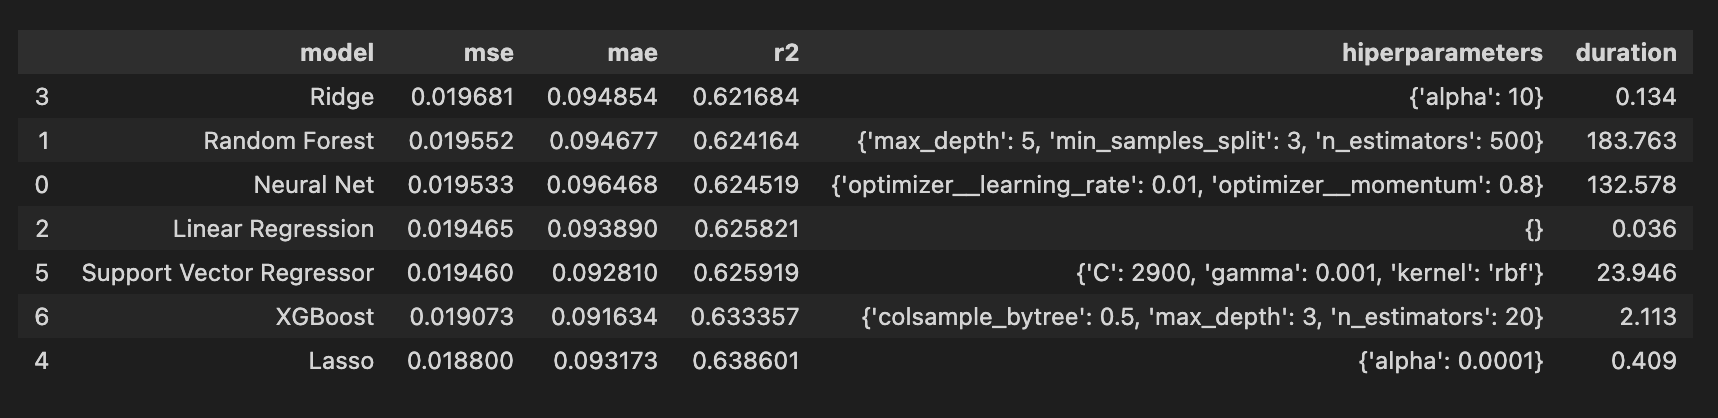

According to the data collected during this project, the best model is the XGBoost. This model has the lowest MSE of 0.019073, which means that it has the smallest average error between the predicted values and the actual values. It also has the lowest MAE of 0.091634, which means that it has the smallest average difference between predicted and actual values. Finally, it has the highest R^2 of 0.633357, which means that it explains 63.33% of the variability in the data.

The other models also perform well, but XGBoost is the best in all evaluation criteria.

- MSE (Mean Squared Error) is an error metric that measures the root mean square difference between predicted and actual values. A lower value of MSE indicates a better fit of the model to the data.

- MAE (Mean Absolute Error) is another error metric that measures the average difference between predicted and actual values. A lower MAE value also indicates a better fit of the model to the data.

- R^2 (Coefficient of Determination) is a fit metric that measures the proportion of the variability in the data that is explained by the model. A higher value of R^2 indicates a better fit of the model to the data.

__Model Results__ 

In this case, XGBoost has the lowest MSE, meaning that it has the smallest average error between predicted and actual values. It also has the lowest MAE, which means that it has the smallest average difference between the predicted and actual values. Finally, it has the highest R^2, meaning that it explains 63.33% of the variability in the data. Based on these criteria, XGBoost is the best model.


The results of XGBoost are very promising. The model has a very low average error of only 0.091634. This means that the values predicted by the model are very close to the actual values. Furthermore, the model explains 63.33% of the variability of the data. This means that the model is able to capture most of the relationships between the variables and the value to be predicted.

Overall, the XGBoost results indicate that the model is very reliable. The model is able to generate accurate predictions and explain the variability of the data.

However, it is important to note that the results of the model may vary depending on the data used to train it. If the data used to train the model are not representative of the data that will be used to make predictions, then the model results may not be as accurate.

In addition, it is important to keep in mind that the XGBoost model is a complex model. It is important to set the model parameters correctly to get the best performance.